In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [ ]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_43.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(43, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.585896,93.262382,92.376886,93.594862,94.408425,93.445690
공시지가(만원),76.880842,75.533711,76.290929,75.605703,79.045383,76.671314
year_linear,64.099953,63.704039,63.705342,67.273280,62.744964,64.305516
건축년도,48.728769,48.516957,48.006189,51.584938,48.915165,49.150404
전용면적,37.670910,38.650777,38.866730,41.297803,37.709567,38.839158


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.585896,93.262382,92.376886,93.594862,94.408425,93.445690
공시지가(만원),76.880842,75.533711,76.290929,75.605703,79.045383,76.671314
year_linear,64.099953,63.704039,63.705342,67.273280,62.744964,64.305516
건축년도,48.728769,48.516957,48.006189,51.584938,48.915165,49.150404
전용면적,37.670910,38.650777,38.866730,41.297803,37.709567,38.839158
ynorm,31.204228,29.965851,31.785528,30.609470,30.148801,30.742776
xy,22.165540,21.232864,22.343831,22.979876,20.984277,21.941278
x_2nd,19.403770,19.470686,18.247213,20.904904,19.360753,19.477465
주건축물수,14.282854,13.331193,14.810889,13.414062,13.577355,13.883270
층mean,11.274431,10.356003,11.556881,10.722629,12.155694,11.213127


In [14]:
top_42_df = shap_summary_df.iloc[:42,:]
print(top_42_df.shape)

(42, 6)


In [15]:
top_42_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.585896,93.262382,92.376886,93.594862,94.408425,93.445690
공시지가(만원),76.880842,75.533711,76.290929,75.605703,79.045383,76.671314
year_linear,64.099953,63.704039,63.705342,67.273280,62.744964,64.305516
건축년도,48.728769,48.516957,48.006189,51.584938,48.915165,49.150404
전용면적,37.670910,38.650777,38.866730,41.297803,37.709567,38.839158


In [16]:
top_42_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
층norm,4.039086,3.877633,3.848370,3.654862,3.487443,3.781479
부속건축물수,3.733755,3.020823,3.189048,3.166929,3.460903,3.314292
지구단위계획구역,3.093371,3.199333,3.169036,3.177984,3.234172,3.174779
가축사육제한구역,2.712194,2.760333,2.536007,2.466741,2.685555,2.632166
도로접면,2.454403,2.550956,2.538284,2.769174,2.641788,2.590921
지붕_평지붕_fraction,2.543912,2.271981,2.505952,2.515882,2.535504,2.474646
건물나이,2.348557,2.216972,2.362706,2.488596,2.587386,2.400843
지형높이,2.744584,2.372464,2.402231,2.238290,2.246429,2.400800
부속건축물면적,2.061473,1.976717,2.610073,2.696075,2.284635,2.325795
층min,2.186736,2.297483,2.500846,2.187145,2.268360,2.288114


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_42_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 47)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,호수대비연면적,xnorm,아파트지구,호수대비부속건축물면적,옥내자주식대수,총호수,층,호수대비주차수,용도지역명1,y_2nd,층norm,부속건축물수,지구단위계획구역,가축사육제한구역,도로접면,지붕_평지붕_fraction,건물나이,지형높이,부속건축물면적,층min,옥외자주식대수,month_sin,(한강)폐기물매립시설_설치제한지역,공원,지형형상,x_sin,y_cos,y_sin,x_cos,제3종일반주거지역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,54.0,2,0.0,0,4.094180e+07,0.222222,0.0,0,0,0,1.0,0,0,0.0,9.0,0.0,-0.866025,0,0,0,-0.364267,0.390815,-0.920469,0.931294,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,54.0,2,0.0,0,4.094180e+07,0.222222,0.0,0,0,0,1.0,0,0,0.0,9.0,0.0,-0.500000,0,0,0,-0.364267,0.390815,-0.920469,0.931294,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,54.0,4,0.0,0,4.094180e+07,0.444444,0.0,0,0,0,1.0,0,0,0.0,9.0,0.0,0.000000,0,0,0,-0.364267,0.390815,-0.920469,0.931294,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,54.0,9,0.0,0,4.094180e+07,1.000000,0.0,0,0,0,1.0,0,0,0.0,9.0,0.0,0.866025,0,0,0,-0.364267,0.390815,-0.920469,0.931294,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0,0.0,0.0,54.0,1,0.0,0,4.094180e+07,0.111111,0.0,0,0,0,1.0,0,0,0.0,9.0,0.0,-0.866025,0,0,0,-0.364267,0.390815,-0.920469,0.931294,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

13

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 42)
y dist plot


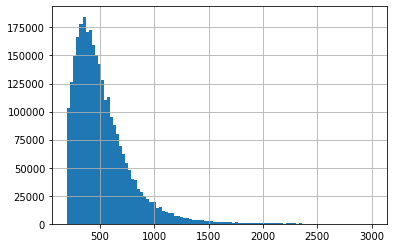

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5920
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 42


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6589
[100]	valid_0's huber: 64.9946
[150]	valid_0's huber: 58.7734
[200]	valid_0's huber: 54.87
[250]	valid_0's huber: 52.6125
[300]	valid_0's huber: 50.8563
[350]	valid_0's huber: 49.4585
[400]	valid_0's huber: 48.4024
[450]	valid_0's huber: 47.4407
[500]	valid_0's huber: 46.7102
[550]	valid_0's huber: 45.9913
[600]	valid_0's huber: 45.3433
[650]	valid_0's huber: 44.8116
[700]	valid_0's huber: 44.4057
[750]	valid_0's huber: 43.8686
[800]	valid_0's huber: 43.4595
[850]	valid_0's huber: 43.0508
[900]	valid_0's huber: 42.71
[950]	valid_0's huber: 42.3841
[1000]	valid_0's huber: 42.0831
[1050]	valid_0's huber: 41.7531
[1100]	valid_0's huber: 41.4649
[1150]	valid_0's huber: 41.203
[1200]	valid_0's huber: 40.9779
[1250]	valid_0's huber: 40.7089
[1300]	valid_0's huber: 40.4782
[1350]	valid_0's huber: 40.2407
[1400]	valid_0's huber: 40.0642
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


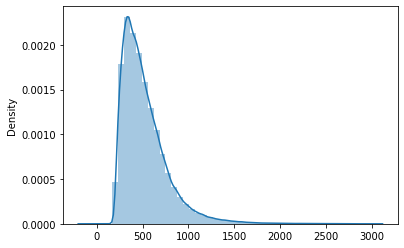

Fold 0 end
Fold 1 start
(2926581, 42)
y dist plot


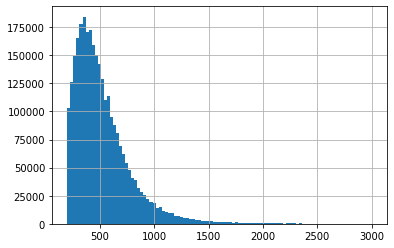

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5921
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 42


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6225
[100]	valid_0's huber: 64.8615
[150]	valid_0's huber: 58.7026
[200]	valid_0's huber: 55.0845
[250]	valid_0's huber: 52.6766
[300]	valid_0's huber: 50.9394
[350]	valid_0's huber: 49.5724
[400]	valid_0's huber: 48.4561
[450]	valid_0's huber: 47.4904
[500]	valid_0's huber: 46.649
[550]	valid_0's huber: 46.0472
[600]	valid_0's huber: 45.3698
[650]	valid_0's huber: 44.7594
[700]	valid_0's huber: 44.2423
[750]	valid_0's huber: 43.8
[800]	valid_0's huber: 43.4105
[850]	valid_0's huber: 42.9793
[900]	valid_0's huber: 42.5634
[950]	valid_0's huber: 42.2314
[1000]	valid_0's huber: 41.9541
[1050]	valid_0's huber: 41.6857
[1100]	valid_0's huber: 41.3871
[1150]	valid_0's huber: 41.1216
[1200]	valid_0's huber: 40.8442
[1250]	valid_0's huber: 40.6162
[1300]	valid_0's huber: 40.3944
[1350]	valid_0's huber: 40.1935
[1400]	valid_0's huber: 39.9967
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


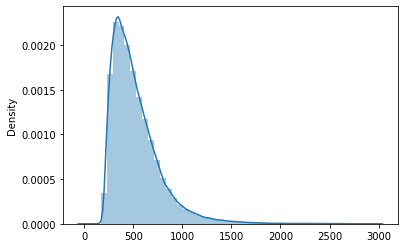

Fold 1 end
Fold 2 start
(2926581, 42)
y dist plot


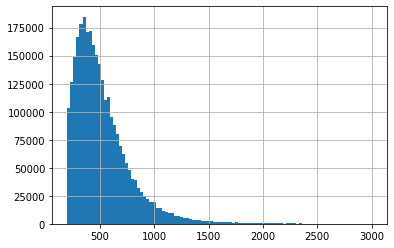

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5923
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 42


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5284
[100]	valid_0's huber: 64.7684
[150]	valid_0's huber: 58.6792
[200]	valid_0's huber: 55.0414
[250]	valid_0's huber: 52.7535
[300]	valid_0's huber: 50.9712
[350]	valid_0's huber: 49.4766
[400]	valid_0's huber: 48.393
[450]	valid_0's huber: 47.4771
[500]	valid_0's huber: 46.6473
[550]	valid_0's huber: 45.9548
[600]	valid_0's huber: 45.3614
[650]	valid_0's huber: 44.8111
[700]	valid_0's huber: 44.3234
[750]	valid_0's huber: 43.8669
[800]	valid_0's huber: 43.4524
[850]	valid_0's huber: 43.1164
[900]	valid_0's huber: 42.7576
[950]	valid_0's huber: 42.4155
[1000]	valid_0's huber: 42.096
[1050]	valid_0's huber: 41.7918
[1100]	valid_0's huber: 41.5261
[1150]	valid_0's huber: 41.268
[1200]	valid_0's huber: 41.0168
[1250]	valid_0's huber: 40.786
[1300]	valid_0's huber: 40.5667
[1350]	valid_0's huber: 40.3735
[1400]	valid_0's huber: 40.1773
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


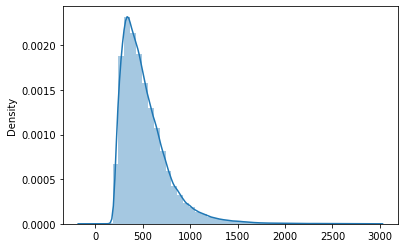

Fold 2 end
Fold 3 start
(2926581, 42)
y dist plot


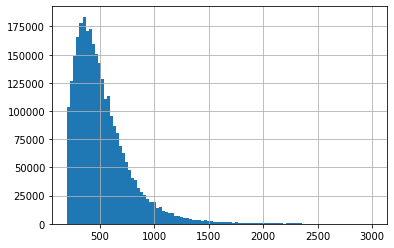

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5917
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 42


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4175
[100]	valid_0's huber: 64.88
[150]	valid_0's huber: 58.7565
[200]	valid_0's huber: 55.0006
[250]	valid_0's huber: 52.6133
[300]	valid_0's huber: 50.8001
[350]	valid_0's huber: 49.5452
[400]	valid_0's huber: 48.4541
[450]	valid_0's huber: 47.5322
[500]	valid_0's huber: 46.7078
[550]	valid_0's huber: 46.0045
[600]	valid_0's huber: 45.417
[650]	valid_0's huber: 44.9235
[700]	valid_0's huber: 44.3256
[750]	valid_0's huber: 43.8154
[800]	valid_0's huber: 43.303
[850]	valid_0's huber: 42.8736
[900]	valid_0's huber: 42.511
[950]	valid_0's huber: 42.1999
[1000]	valid_0's huber: 41.9124
[1050]	valid_0's huber: 41.6455
[1100]	valid_0's huber: 41.3712
[1150]	valid_0's huber: 41.1006
[1200]	valid_0's huber: 40.8844
[1250]	valid_0's huber: 40.6671
[1300]	valid_0's huber: 40.4501
[1350]	valid_0's huber: 40.2653
[1400]	valid_0's huber: 40.0826
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


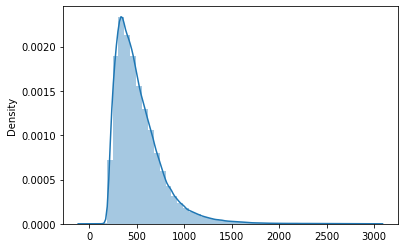

Fold 3 end
Fold 4 start
(2926581, 42)
y dist plot


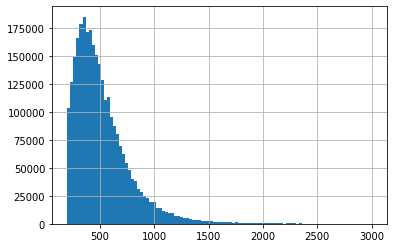

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 42


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4462
[100]	valid_0's huber: 64.6355
[150]	valid_0's huber: 58.6236
[200]	valid_0's huber: 54.9606
[250]	valid_0's huber: 52.622
[300]	valid_0's huber: 50.9245
[350]	valid_0's huber: 49.5583
[400]	valid_0's huber: 48.4228
[450]	valid_0's huber: 47.4311
[500]	valid_0's huber: 46.6672
[550]	valid_0's huber: 46.0447
[600]	valid_0's huber: 45.4228
[650]	valid_0's huber: 44.8907
[700]	valid_0's huber: 44.336
[750]	valid_0's huber: 43.8331
[800]	valid_0's huber: 43.3562
[850]	valid_0's huber: 42.9487
[900]	valid_0's huber: 42.6557
[950]	valid_0's huber: 42.3379
[1000]	valid_0's huber: 42.0406
[1050]	valid_0's huber: 41.7086
[1100]	valid_0's huber: 41.4426
[1150]	valid_0's huber: 41.1837
[1200]	valid_0's huber: 40.9413
[1250]	valid_0's huber: 40.7061
[1300]	valid_0's huber: 40.4976
[1350]	valid_0's huber: 40.3022
[1400]	valid_0's huber: 40.111
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


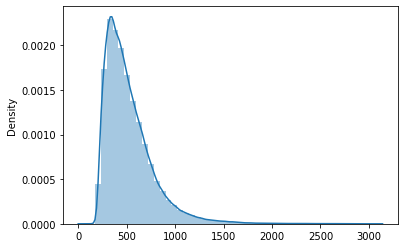

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_42_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

66.12929960273902

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_42.csv')

In [33]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.666305,92.098570,89.729737,91.790236,92.226629,91.502295
공시지가(만원),75.047147,80.313305,74.846738,78.852508,78.059009,77.423741
year_linear,63.521352,63.250525,64.580640,64.283279,64.526651,64.032489
건축년도,50.437386,48.353293,46.829052,49.325853,48.189168,48.626950
전용면적,36.259078,38.420910,40.918271,37.030822,34.428492,37.411514
ynorm,30.318798,31.229665,31.435159,29.590870,29.881214,30.491141
xy,21.078881,22.026681,18.634365,23.023101,20.955739,21.143753
x_2nd,19.380858,17.571474,19.273309,19.551680,18.427705,18.841005
주건축물수,12.155295,13.258588,13.652012,13.213066,12.814597,13.018712
층mean,10.340482,10.321457,10.139596,10.453713,11.114674,10.473984


In [34]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
옥외자주식대수,2.029396,2.530522,2.135630,2.569325,1.927335,2.238442
month_sin,2.337809,2.199214,2.163926,2.372913,2.409045,2.296581
(한강)폐기물매립시설_설치제한지역,2.017720,2.127642,2.147718,2.145256,2.391942,2.166055
공원,1.698762,2.455534,1.980155,1.986994,2.271502,2.078589
지형형상,1.359713,1.388681,1.402917,1.538823,1.397593,1.417545
x_sin,1.304148,1.239214,1.272761,1.255154,1.223413,1.258938
y_cos,1.470687,1.375137,1.216189,1.188014,1.211855,1.292377
y_sin,1.242797,1.387134,1.312839,1.207551,1.184802,1.267025
x_cos,1.160568,1.163975,1.193187,1.239034,1.398610,1.231075
제3종일반주거지역,0.967137,1.066393,1.226671,1.035992,0.965403,1.052320


In [35]:
#